In [1]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.io import read_image

class Birds270Dataset(Dataset):
    def make_labels(self, csv_table):
        bird_str_labels = csv_table["labels"].unique()
        self.labels_str_to_int = {label:i  for i, label in enumerate(bird_str_labels)}
        self.labels_int_to_str = {i:label  for i, label in enumerate(bird_str_labels)}
        
    def __init__(self, dataset_dir, set_type="train", transform=None, selected_birds=None):
        csv_table = pd.read_csv(os.path.join(dataset_dir, "birds.csv"))
        if selected_birds != None:
            csv_table = csv_table[csv_table["labels"].isin(selected_birds)]
        self.img_data = csv_table[csv_table["data set"]==set_type]
        self.make_labels(self.img_data)
        self.dataset_dir = dataset_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        filepaths_col = self.img_data.columns.get_loc("filepaths")
        labels_col = self.img_data.columns.get_loc("labels")
        img_path = os.path.join(self.dataset_dir, self.img_data.iat[idx, filepaths_col])
        image = read_image(img_path).float()
        label = self.img_data.iat[idx, labels_col]
        if self.transform:
            image = self.transform(image)
        int_label = self.labels_str_to_int[label]
        return image, int_label
    
            
    

In [2]:
dataset_dir = "../data/birds270"
selected_birds = ["ALBATROSS", "BALD EAGLE", "BARN OWL", "EURASIAN MAGPIE", "FLAMINGO",
                  "MALLARD DUCK", "OSTRICH", "PEACOCK", "PELICAN", "TRUMPTER SWAN"]
tr = transforms.Normalize((127.5, 127.5, 127.5), (127.5, 127.5, 127.5)) # normalizes colors to range [-1,1]
train_dataset = Birds270Dataset(dataset_dir, set_type="train", selected_birds=selected_birds, transform=tr)
test_dataset = Birds270Dataset(dataset_dir, set_type="test", selected_birds=selected_birds, transform=tr)

In [3]:
from torch.utils.data import DataLoader

batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 24, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(24 * 56 * 56, 100)
        self.output = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 24 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.output(x)
        return x

    
net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [6]:
import datetime

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    epoch_loss = 0
    start_time = datetime.datetime.now()
        
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        loss.backward()
        optimizer.step()

    time_elapsed = datetime.datetime.now() - start_time
    epoch_loss = running_loss / len(train_dataloader.dataset)
    # print statistics
    print(f"Epoch {epoch}:")
    print(f"\ttrain loss: {epoch_loss}")
    print(f"\tElapsed time: {time_elapsed}") 

print('Finished Training')

Epoch 0:
	train loss: 1.7710736934671696
	Elapsed time: 0:00:47.088066
Epoch 1:
	train loss: 1.0775302992653601
	Elapsed time: 0:00:34.615353
Finished Training


In [7]:
torch.save(net, '../model/simple_PW_model.pth')
torch.save(net.state_dict(), '../model/simple_PW_model_weights.pth')

In [8]:
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

In [9]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network: %d %%' % (100 * correct / total))

Accuracy of the network: 72 %


In [10]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in selected_birds}
total_pred = {classname: 0 for classname in selected_birds}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[selected_birds[label]] += 1
            total_pred[selected_birds[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class ALBATROSS is: 20.0 %
Accuracy for class BALD EAGLE is: 80.0 %
Accuracy for class BARN OWL is: 80.0 %
Accuracy for class EURASIAN MAGPIE is: 100.0 %
Accuracy for class FLAMINGO is: 80.0 %
Accuracy for class MALLARD DUCK is: 100.0 %
Accuracy for class OSTRICH is: 60.0 %
Accuracy for class PEACOCK is: 100.0 %
Accuracy for class PELICAN is: 60.0 %
Accuracy for class TRUMPTER SWAN is: 40.0 %


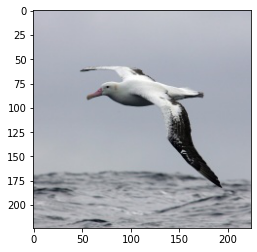

Label (number): 0, (name): ALBATROSS
[('TRUMPTER SWAN', 0.3645663559436798), ('ALBATROSS', 0.20079055428504944), ('BARN OWL', 0.11699695885181427), ('BALD EAGLE', 0.10839565098285675), ('PELICAN', 0.09802214056253433), ('MALLARD DUCK', 0.04703289270401001), ('FLAMINGO', 0.0257127583026886), ('EURASIAN MAGPIE', 0.019421128556132317), ('OSTRICH', 0.018842453137040138), ('PEACOCK', 0.0002191172679886222)]


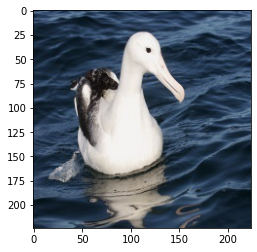

Label (number): 0, (name): ALBATROSS
[('TRUMPTER SWAN', 0.5051050782203674), ('PELICAN', 0.2766555845737457), ('ALBATROSS', 0.15914738178253174), ('MALLARD DUCK', 0.029202448204159737), ('BALD EAGLE', 0.015534046106040478), ('EURASIAN MAGPIE', 0.007387521676719189), ('OSTRICH', 0.003941135015338659), ('FLAMINGO', 0.0019408698426559567), ('BARN OWL', 0.0006844620802439749), ('PEACOCK', 0.00040152505971491337)]


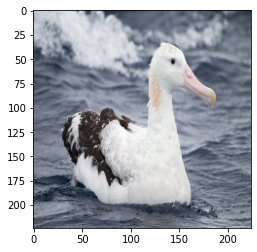

Label (number): 0, (name): ALBATROSS
[('ALBATROSS', 0.4390661418437958), ('TRUMPTER SWAN', 0.2271689921617508), ('BALD EAGLE', 0.20122431218624115), ('PELICAN', 0.07075788825750351), ('BARN OWL', 0.041408877819776535), ('EURASIAN MAGPIE', 0.006912764627486467), ('FLAMINGO', 0.004949228838086128), ('OSTRICH', 0.004730062559247017), ('MALLARD DUCK', 0.0037308181636035442), ('PEACOCK', 5.083957512397319e-05)]


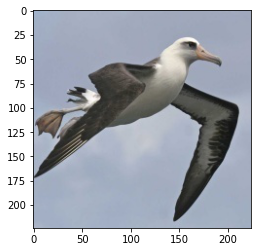

Label (number): 0, (name): ALBATROSS
[('MALLARD DUCK', 0.3219195604324341), ('ALBATROSS', 0.20415788888931274), ('TRUMPTER SWAN', 0.14981533586978912), ('EURASIAN MAGPIE', 0.1125916987657547), ('PELICAN', 0.1089428961277008), ('BALD EAGLE', 0.05888702720403671), ('OSTRICH', 0.026382438838481903), ('FLAMINGO', 0.008979550562798977), ('BARN OWL', 0.007675121072679758), ('PEACOCK', 0.0006485524936579168)]


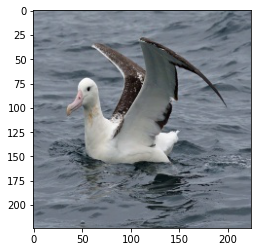

Label (number): 0, (name): ALBATROSS
[('TRUMPTER SWAN', 0.22880257666110992), ('EURASIAN MAGPIE', 0.2279331237077713), ('MALLARD DUCK', 0.1374071091413498), ('PELICAN', 0.12355304509401321), ('ALBATROSS', 0.11668894439935684), ('BALD EAGLE', 0.050843868404626846), ('PEACOCK', 0.03892151266336441), ('OSTRICH', 0.028825633227825165), ('FLAMINGO', 0.0259788166731596), ('BARN OWL', 0.021045420318841934)]


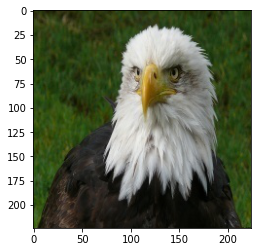

Label (number): 1, (name): BALD EAGLE
[('BALD EAGLE', 0.6355468034744263), ('BARN OWL', 0.10160601884126663), ('TRUMPTER SWAN', 0.08335727453231812), ('ALBATROSS', 0.06518346816301346), ('PELICAN', 0.06450070440769196), ('FLAMINGO', 0.02512975223362446), ('OSTRICH', 0.009646293707191944), ('MALLARD DUCK', 0.007503053639084101), ('EURASIAN MAGPIE', 0.006950714625418186), ('PEACOCK', 0.0005758623010478914)]


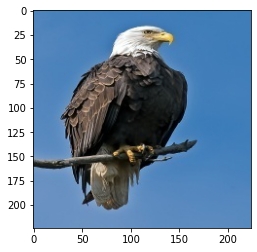

Label (number): 1, (name): BALD EAGLE
[('BALD EAGLE', 0.3264963626861572), ('PELICAN', 0.26255446672439575), ('EURASIAN MAGPIE', 0.1332104653120041), ('ALBATROSS', 0.07065059244632721), ('MALLARD DUCK', 0.05412503331899643), ('OSTRICH', 0.048857975751161575), ('FLAMINGO', 0.04827289655804634), ('PEACOCK', 0.03504530340433121), ('TRUMPTER SWAN', 0.01742541417479515), ('BARN OWL', 0.0033616500440984964)]


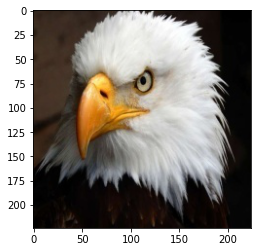

Label (number): 1, (name): BALD EAGLE
[('BALD EAGLE', 0.9352190494537354), ('BARN OWL', 0.05068572983145714), ('ALBATROSS', 0.006911957170814276), ('FLAMINGO', 0.0038183247670531273), ('PELICAN', 0.0018692734884098172), ('TRUMPTER SWAN', 0.001348392921499908), ('OSTRICH', 8.304391667479649e-05), ('EURASIAN MAGPIE', 4.974589683115482e-05), ('MALLARD DUCK', 1.3467029930325225e-05), ('PEACOCK', 1.0327661357223406e-06)]


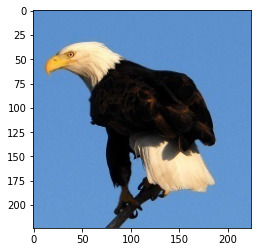

Label (number): 1, (name): BALD EAGLE
[('MALLARD DUCK', 0.22715836763381958), ('EURASIAN MAGPIE', 0.18765661120414734), ('BALD EAGLE', 0.18635907769203186), ('PELICAN', 0.13902561366558075), ('FLAMINGO', 0.08968915790319443), ('ALBATROSS', 0.059238798916339874), ('OSTRICH', 0.05623365566134453), ('PEACOCK', 0.03298506885766983), ('TRUMPTER SWAN', 0.014007963240146637), ('BARN OWL', 0.007645654492080212)]


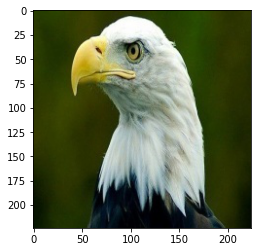

Label (number): 1, (name): BALD EAGLE
[('BALD EAGLE', 0.8932022452354431), ('ALBATROSS', 0.03368137404322624), ('BARN OWL', 0.02408052608370781), ('TRUMPTER SWAN', 0.021483207121491432), ('FLAMINGO', 0.011947066523134708), ('PELICAN', 0.011392145417630672), ('EURASIAN MAGPIE', 0.0021499202121049166), ('OSTRICH', 0.0015805383445695043), ('MALLARD DUCK', 0.0003411612706258893), ('PEACOCK', 0.00014187315537128597)]


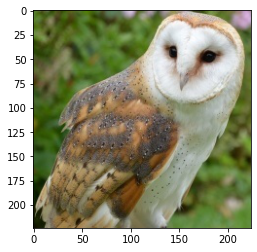

Label (number): 2, (name): BARN OWL
[('BARN OWL', 0.588397741317749), ('MALLARD DUCK', 0.09797422587871552), ('FLAMINGO', 0.08371610939502716), ('BALD EAGLE', 0.06268396973609924), ('OSTRICH', 0.06053903326392174), ('PELICAN', 0.04698319360613823), ('ALBATROSS', 0.03495987504720688), ('TRUMPTER SWAN', 0.01505278516560793), ('EURASIAN MAGPIE', 0.007206381298601627), ('PEACOCK', 0.002486656652763486)]


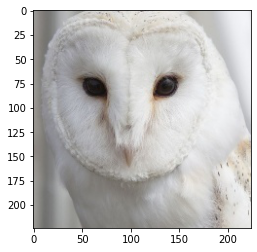

Label (number): 2, (name): BARN OWL
[('TRUMPTER SWAN', 0.3471164107322693), ('BARN OWL', 0.27119749784469604), ('BALD EAGLE', 0.08801180869340897), ('ALBATROSS', 0.08703142404556274), ('PELICAN', 0.08114080876111984), ('MALLARD DUCK', 0.05559515580534935), ('OSTRICH', 0.03602070361375809), ('FLAMINGO', 0.025133676826953888), ('EURASIAN MAGPIE', 0.008444627746939659), ('PEACOCK', 0.00030787874129600823)]


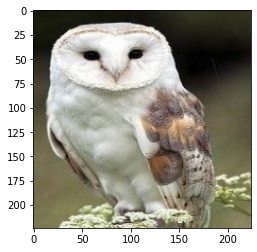

Label (number): 2, (name): BARN OWL
[('BARN OWL', 0.7221118211746216), ('BALD EAGLE', 0.14228567481040955), ('FLAMINGO', 0.08023165911436081), ('TRUMPTER SWAN', 0.029937515035271645), ('PELICAN', 0.01182518433779478), ('ALBATROSS', 0.007547363173216581), ('OSTRICH', 0.0034494176506996155), ('EURASIAN MAGPIE', 0.001468162750825286), ('MALLARD DUCK', 0.0009343131096102297), ('PEACOCK', 0.00020884237892460078)]


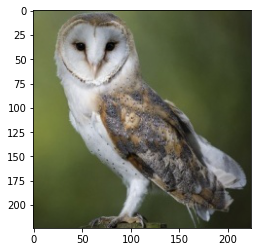

Label (number): 2, (name): BARN OWL
[('BARN OWL', 0.3093712627887726), ('BALD EAGLE', 0.20273476839065552), ('TRUMPTER SWAN', 0.14385966956615448), ('FLAMINGO', 0.11103836447000504), ('ALBATROSS', 0.08045811951160431), ('PELICAN', 0.06263340264558792), ('EURASIAN MAGPIE', 0.04237576201558113), ('MALLARD DUCK', 0.018576141446828842), ('OSTRICH', 0.01803658716380596), ('PEACOCK', 0.010915929451584816)]


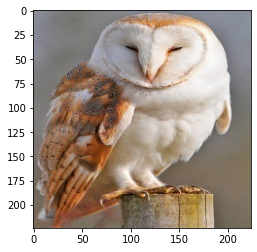

Label (number): 2, (name): BARN OWL
[('BARN OWL', 0.9503527879714966), ('FLAMINGO', 0.013960391283035278), ('BALD EAGLE', 0.010433696210384369), ('MALLARD DUCK', 0.009197695180773735), ('OSTRICH', 0.008932698518037796), ('ALBATROSS', 0.002944673178717494), ('PELICAN', 0.0027581574395298958), ('TRUMPTER SWAN', 0.0009489440126344562), ('EURASIAN MAGPIE', 0.00043937074951827526), ('PEACOCK', 3.161632048431784e-05)]


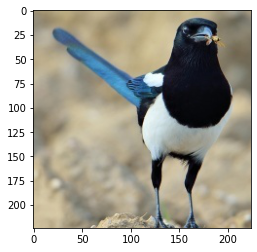

Label (number): 3, (name): EURASIAN MAGPIE
[('EURASIAN MAGPIE', 0.8809774518013), ('MALLARD DUCK', 0.044670604169368744), ('OSTRICH', 0.044176068156957626), ('PEACOCK', 0.007936683483421803), ('TRUMPTER SWAN', 0.005070595536381006), ('BARN OWL', 0.005036097019910812), ('PELICAN', 0.004284411668777466), ('ALBATROSS', 0.003745750291272998), ('BALD EAGLE', 0.0025309917982667685), ('FLAMINGO', 0.001571294735185802)]


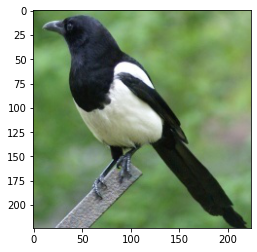

Label (number): 3, (name): EURASIAN MAGPIE
[('EURASIAN MAGPIE', 0.29655906558036804), ('PELICAN', 0.21323123574256897), ('TRUMPTER SWAN', 0.13550950586795807), ('ALBATROSS', 0.09944356232881546), ('MALLARD DUCK', 0.07341402769088745), ('PEACOCK', 0.06551338732242584), ('FLAMINGO', 0.03739529103040695), ('OSTRICH', 0.03392309322953224), ('BALD EAGLE', 0.026610229164361954), ('BARN OWL', 0.01840062625706196)]


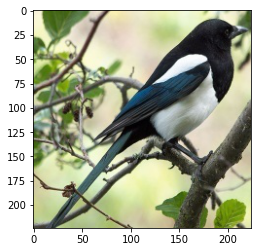

Label (number): 3, (name): EURASIAN MAGPIE
[('EURASIAN MAGPIE', 0.7017271518707275), ('ALBATROSS', 0.05894893407821655), ('OSTRICH', 0.05299876630306244), ('PELICAN', 0.05015304684638977), ('MALLARD DUCK', 0.04095638915896416), ('TRUMPTER SWAN', 0.030285922810435295), ('BALD EAGLE', 0.026470810174942017), ('PEACOCK', 0.022746218368411064), ('BARN OWL', 0.009898349642753601), ('FLAMINGO', 0.005814460571855307)]


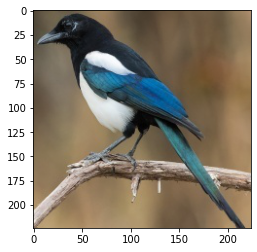

Label (number): 3, (name): EURASIAN MAGPIE
[('EURASIAN MAGPIE', 0.9120201468467712), ('OSTRICH', 0.04744640365242958), ('MALLARD DUCK', 0.01823224499821663), ('PEACOCK', 0.01817934215068817), ('ALBATROSS', 0.0014836718328297138), ('TRUMPTER SWAN', 0.0007539422367699444), ('PELICAN', 0.0005861008539795876), ('BALD EAGLE', 0.0005583364400081336), ('BARN OWL', 0.0005130758509039879), ('FLAMINGO', 0.0002266830124426633)]


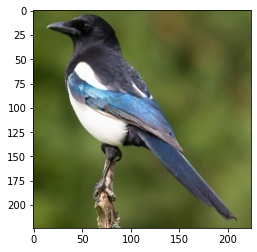

Label (number): 3, (name): EURASIAN MAGPIE
[('EURASIAN MAGPIE', 0.5351971387863159), ('TRUMPTER SWAN', 0.1033691018819809), ('PEACOCK', 0.07351873815059662), ('ALBATROSS', 0.06325772404670715), ('PELICAN', 0.0491824634373188), ('MALLARD DUCK', 0.0480177067220211), ('BARN OWL', 0.034575145691633224), ('FLAMINGO', 0.033160656690597534), ('OSTRICH', 0.03180798143148422), ('BALD EAGLE', 0.027913277968764305)]


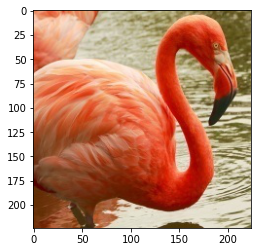

Label (number): 4, (name): FLAMINGO
[('FLAMINGO', 0.9999593496322632), ('BARN OWL', 4.0198232454713434e-05), ('MALLARD DUCK', 4.851098651670327e-07), ('OSTRICH', 4.3200720778457935e-10), ('PELICAN', 3.2121263981998993e-10), ('BALD EAGLE', 3.0518525206968405e-11), ('PEACOCK', 6.164203262409851e-12), ('ALBATROSS', 2.223787695871185e-13), ('EURASIAN MAGPIE', 2.421891924628863e-16), ('TRUMPTER SWAN', 5.2379279996009554e-17)]


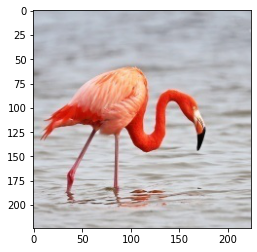

Label (number): 4, (name): FLAMINGO
[('BARN OWL', 0.5986316204071045), ('FLAMINGO', 0.31793826818466187), ('MALLARD DUCK', 0.06451563537120819), ('PELICAN', 0.010560616850852966), ('OSTRICH', 0.006229668390005827), ('BALD EAGLE', 0.001850486733019352), ('ALBATROSS', 0.00015647774853277951), ('TRUMPTER SWAN', 0.0001052457228070125), ('PEACOCK', 6.3697470977786e-06), ('EURASIAN MAGPIE', 5.613236226054141e-06)]


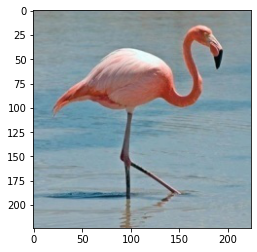

Label (number): 4, (name): FLAMINGO
[('FLAMINGO', 0.9736310839653015), ('BARN OWL', 0.008666085079312325), ('PELICAN', 0.006585753057152033), ('BALD EAGLE', 0.005468632094562054), ('MALLARD DUCK', 0.0021171728149056435), ('PEACOCK', 0.0012390021001920104), ('ALBATROSS', 0.0008536645909771323), ('EURASIAN MAGPIE', 0.000697404146194458), ('OSTRICH', 0.0005006102146580815), ('TRUMPTER SWAN', 0.0002406292041996494)]


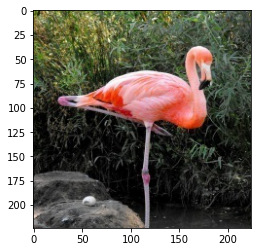

Label (number): 4, (name): FLAMINGO
[('FLAMINGO', 0.9726401567459106), ('MALLARD DUCK', 0.010269399732351303), ('BARN OWL', 0.009396225214004517), ('PELICAN', 0.00601209606975317), ('PEACOCK', 0.0005869029555469751), ('BALD EAGLE', 0.0004348988295532763), ('ALBATROSS', 0.0003147004754282534), ('OSTRICH', 0.0002883052220568061), ('TRUMPTER SWAN', 4.848809112445451e-05), ('EURASIAN MAGPIE', 8.728201464691665e-06)]


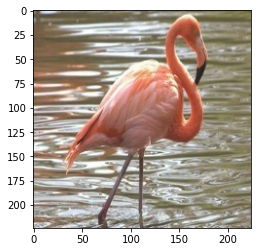

Label (number): 4, (name): FLAMINGO
[('FLAMINGO', 0.9835313558578491), ('BARN OWL', 0.01484966091811657), ('MALLARD DUCK', 0.0008193417452275753), ('PELICAN', 0.0005734201404266059), ('PEACOCK', 8.084592263912782e-05), ('BALD EAGLE', 6.2011786212679e-05), ('OSTRICH', 5.2018156566191465e-05), ('ALBATROSS', 2.355550168431364e-05), ('TRUMPTER SWAN', 5.8471778174862266e-06), ('EURASIAN MAGPIE', 1.8420944343233714e-06)]


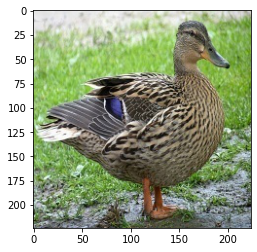

Label (number): 5, (name): MALLARD DUCK
[('MALLARD DUCK', 0.376894474029541), ('EURASIAN MAGPIE', 0.1544177085161209), ('ALBATROSS', 0.13616648316383362), ('PELICAN', 0.11992823332548141), ('OSTRICH', 0.08242882043123245), ('PEACOCK', 0.055398426949977875), ('BALD EAGLE', 0.02888503298163414), ('TRUMPTER SWAN', 0.023120403289794922), ('FLAMINGO', 0.012817967683076859), ('BARN OWL', 0.0099424347281456)]


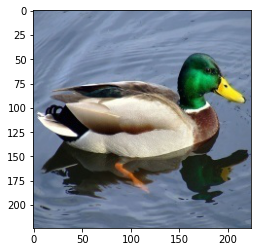

Label (number): 5, (name): MALLARD DUCK
[('MALLARD DUCK', 0.6546643376350403), ('ALBATROSS', 0.12125351279973984), ('PELICAN', 0.0937349945306778), ('TRUMPTER SWAN', 0.05538499727845192), ('BALD EAGLE', 0.021950488910079002), ('BARN OWL', 0.016096394509077072), ('EURASIAN MAGPIE', 0.013179671950638294), ('FLAMINGO', 0.011201123706996441), ('OSTRICH', 0.010610230267047882), ('PEACOCK', 0.0019242543494328856)]


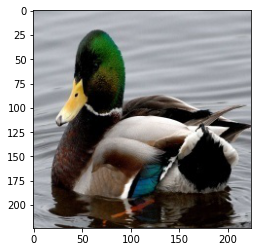

Label (number): 5, (name): MALLARD DUCK
[('MALLARD DUCK', 0.4082104563713074), ('PELICAN', 0.33278554677963257), ('ALBATROSS', 0.06568725407123566), ('EURASIAN MAGPIE', 0.060108836740255356), ('OSTRICH', 0.04797875136137009), ('FLAMINGO', 0.027736742049455643), ('BALD EAGLE', 0.0219432320445776), ('BARN OWL', 0.01591131091117859), ('TRUMPTER SWAN', 0.01229942962527275), ('PEACOCK', 0.007338488008826971)]


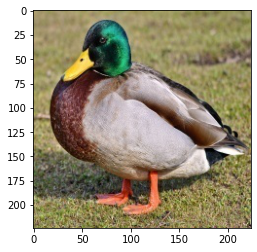

Label (number): 5, (name): MALLARD DUCK
[('MALLARD DUCK', 0.9955812096595764), ('PELICAN', 0.0012070031370967627), ('ALBATROSS', 0.0007357586873695254), ('FLAMINGO', 0.0006194488960318267), ('OSTRICH', 0.0005527649773284793), ('BARN OWL', 0.0004766706842929125), ('BALD EAGLE', 0.0004524255346041173), ('TRUMPTER SWAN', 0.00022988434648141265), ('EURASIAN MAGPIE', 0.00012921009329147637), ('PEACOCK', 1.554206755827181e-05)]


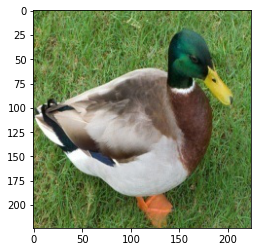

Label (number): 5, (name): MALLARD DUCK
[('MALLARD DUCK', 0.7769150137901306), ('ALBATROSS', 0.06602508574724197), ('PELICAN', 0.05060963332653046), ('TRUMPTER SWAN', 0.048296332359313965), ('BARN OWL', 0.01819387823343277), ('BALD EAGLE', 0.014563502743840218), ('FLAMINGO', 0.010792338289320469), ('OSTRICH', 0.008327246643602848), ('EURASIAN MAGPIE', 0.005223195534199476), ('PEACOCK', 0.001053809653967619)]


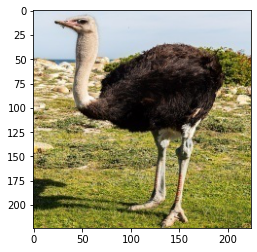

Label (number): 6, (name): OSTRICH
[('OSTRICH', 0.9071242809295654), ('MALLARD DUCK', 0.03527682647109032), ('BARN OWL', 0.03434545174241066), ('BALD EAGLE', 0.012316028587520123), ('EURASIAN MAGPIE', 0.0039041503332555294), ('PEACOCK', 0.0029597675893455744), ('ALBATROSS', 0.0015279222279787064), ('FLAMINGO', 0.001230224035680294), ('PELICAN', 0.0011868540896102786), ('TRUMPTER SWAN', 0.00012855803652200848)]


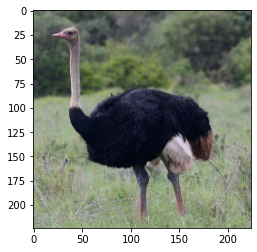

Label (number): 6, (name): OSTRICH
[('EURASIAN MAGPIE', 0.41136226058006287), ('PEACOCK', 0.24678905308246613), ('OSTRICH', 0.18319542706012726), ('MALLARD DUCK', 0.04062887281179428), ('PELICAN', 0.025090482085943222), ('BALD EAGLE', 0.02435993403196335), ('ALBATROSS', 0.02292817272245884), ('TRUMPTER SWAN', 0.01689845323562622), ('FLAMINGO', 0.014563390053808689), ('BARN OWL', 0.014183909632265568)]


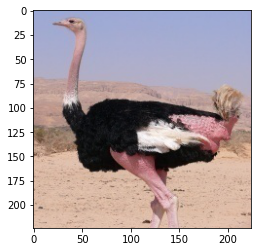

Label (number): 6, (name): OSTRICH
[('OSTRICH', 0.919796347618103), ('MALLARD DUCK', 0.05216195434331894), ('BARN OWL', 0.02026575244963169), ('EURASIAN MAGPIE', 0.003700423054397106), ('BALD EAGLE', 0.001970393816009164), ('FLAMINGO', 0.0009061551536433399), ('PEACOCK', 0.0006415064563043416), ('PELICAN', 0.00031146439141593874), ('ALBATROSS', 0.00022410438396036625), ('TRUMPTER SWAN', 2.1793095584143884e-05)]


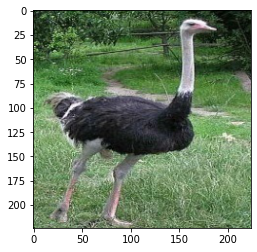

Label (number): 6, (name): OSTRICH
[('TRUMPTER SWAN', 0.37980005145072937), ('ALBATROSS', 0.16725705564022064), ('PELICAN', 0.13500858843326569), ('OSTRICH', 0.08891113847494125), ('BALD EAGLE', 0.07153458148241043), ('MALLARD DUCK', 0.0446433424949646), ('PEACOCK', 0.040051862597465515), ('EURASIAN MAGPIE', 0.03076133131980896), ('BARN OWL', 0.022948624566197395), ('FLAMINGO', 0.019083308055996895)]


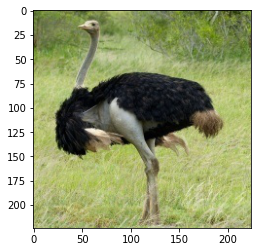

Label (number): 6, (name): OSTRICH
[('OSTRICH', 0.849146842956543), ('EURASIAN MAGPIE', 0.06728270649909973), ('MALLARD DUCK', 0.05105092003941536), ('BARN OWL', 0.012029367499053478), ('PEACOCK', 0.011749760247766972), ('BALD EAGLE', 0.0034717191010713577), ('FLAMINGO', 0.0017195969121530652), ('ALBATROSS', 0.0014039084780961275), ('PELICAN', 0.001086074742488563), ('TRUMPTER SWAN', 0.0010590750025585294)]


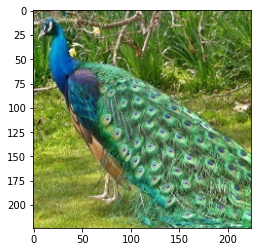

Label (number): 7, (name): PEACOCK
[('PEACOCK', 0.6764033436775208), ('EURASIAN MAGPIE', 0.24850037693977356), ('OSTRICH', 0.03805224224925041), ('TRUMPTER SWAN', 0.011763805523514748), ('ALBATROSS', 0.010666118003427982), ('PELICAN', 0.009873991832137108), ('BALD EAGLE', 0.002084332285448909), ('MALLARD DUCK', 0.0020471233874559402), ('FLAMINGO', 0.0003508269146550447), ('BARN OWL', 0.00025786724290810525)]


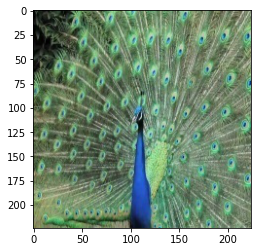

Label (number): 7, (name): PEACOCK
[('PEACOCK', 0.9406101703643799), ('EURASIAN MAGPIE', 0.024716153740882874), ('OSTRICH', 0.01059611327946186), ('ALBATROSS', 0.009701166301965714), ('MALLARD DUCK', 0.003780925180763006), ('PELICAN', 0.003709169337525964), ('TRUMPTER SWAN', 0.003434165380895138), ('BALD EAGLE', 0.002266783732920885), ('FLAMINGO', 0.0009585360530763865), ('BARN OWL', 0.00022680952679365873)]


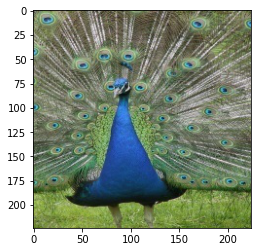

Label (number): 7, (name): PEACOCK
[('PEACOCK', 0.9738741517066956), ('EURASIAN MAGPIE', 0.022709323093295097), ('OSTRICH', 0.001305839978158474), ('ALBATROSS', 0.0007409259560517967), ('MALLARD DUCK', 0.0005562889273278415), ('PELICAN', 0.0004881515051238239), ('TRUMPTER SWAN', 0.00013820145977661014), ('BALD EAGLE', 0.00010262995783705264), ('FLAMINGO', 7.61073169996962e-05), ('BARN OWL', 8.37414881971199e-06)]


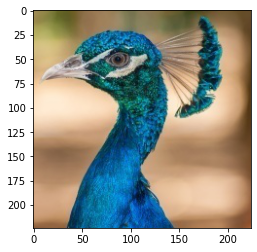

Label (number): 7, (name): PEACOCK
[('PEACOCK', 0.9991965889930725), ('EURASIAN MAGPIE', 0.0007391639519482851), ('MALLARD DUCK', 4.4661694118985906e-05), ('OSTRICH', 1.918850466609001e-05), ('ALBATROSS', 4.051512405567337e-07), ('BALD EAGLE', 2.0416715429405485e-08), ('FLAMINGO', 1.2145927597018158e-09), ('PELICAN', 1.172676511451698e-09), ('TRUMPTER SWAN', 1.1053825632600933e-09), ('BARN OWL', 1.232042523557908e-10)]


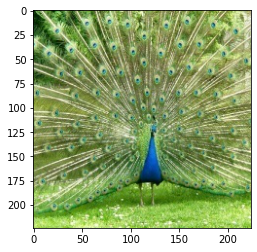

Label (number): 7, (name): PEACOCK
[('PEACOCK', 0.8940318822860718), ('EURASIAN MAGPIE', 0.04678216204047203), ('OSTRICH', 0.019946515560150146), ('ALBATROSS', 0.012533505447208881), ('MALLARD DUCK', 0.009716857224702835), ('PELICAN', 0.006573484744876623), ('BALD EAGLE', 0.004814332816749811), ('TRUMPTER SWAN', 0.0030951309017837048), ('FLAMINGO', 0.0018712100572884083), ('BARN OWL', 0.0006349151954054832)]


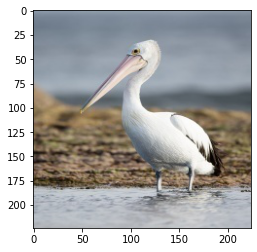

Label (number): 8, (name): PELICAN
[('PELICAN', 0.30807724595069885), ('EURASIAN MAGPIE', 0.27518796920776367), ('MALLARD DUCK', 0.08457750082015991), ('FLAMINGO', 0.0784086138010025), ('TRUMPTER SWAN', 0.06417864561080933), ('ALBATROSS', 0.05550631880760193), ('BALD EAGLE', 0.044778939336538315), ('BARN OWL', 0.04222168028354645), ('OSTRICH', 0.03679434955120087), ('PEACOCK', 0.01026870682835579)]


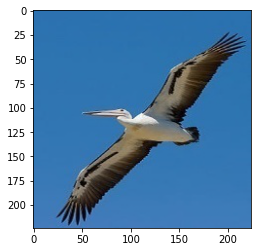

Label (number): 8, (name): PELICAN
[('PELICAN', 0.32858675718307495), ('ALBATROSS', 0.20550726354122162), ('MALLARD DUCK', 0.1687537133693695), ('EURASIAN MAGPIE', 0.134031742811203), ('TRUMPTER SWAN', 0.10291151702404022), ('BALD EAGLE', 0.03265949711203575), ('OSTRICH', 0.01678886078298092), ('PEACOCK', 0.009310580790042877), ('FLAMINGO', 0.0012707242276519537), ('BARN OWL', 0.00017935394134838134)]


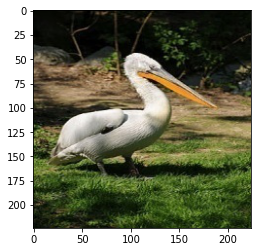

Label (number): 8, (name): PELICAN
[('FLAMINGO', 0.5297116041183472), ('PELICAN', 0.15450423955917358), ('BARN OWL', 0.08454015105962753), ('ALBATROSS', 0.06982404738664627), ('BALD EAGLE', 0.0695822611451149), ('TRUMPTER SWAN', 0.043863411992788315), ('MALLARD DUCK', 0.02867194637656212), ('PEACOCK', 0.007361182942986488), ('EURASIAN MAGPIE', 0.006535717751830816), ('OSTRICH', 0.005405477248132229)]


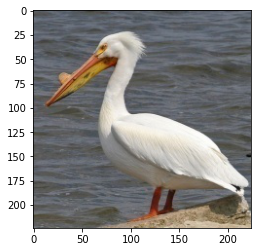

Label (number): 8, (name): PELICAN
[('PELICAN', 0.30627650022506714), ('TRUMPTER SWAN', 0.19116753339767456), ('FLAMINGO', 0.14868992567062378), ('MALLARD DUCK', 0.0838780328631401), ('BALD EAGLE', 0.0757899060845375), ('BARN OWL', 0.0610722117125988), ('ALBATROSS', 0.05756136029958725), ('EURASIAN MAGPIE', 0.04950587451457977), ('OSTRICH', 0.0158549677580595), ('PEACOCK', 0.010203723795711994)]


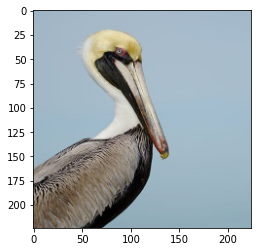

Label (number): 8, (name): PELICAN
[('TRUMPTER SWAN', 0.3187459111213684), ('ALBATROSS', 0.15903176367282867), ('BARN OWL', 0.15015143156051636), ('PELICAN', 0.1454809010028839), ('BALD EAGLE', 0.058020319789648056), ('FLAMINGO', 0.05694979056715965), ('MALLARD DUCK', 0.05048205703496933), ('EURASIAN MAGPIE', 0.04100697860121727), ('OSTRICH', 0.019226649776101112), ('PEACOCK', 0.0009043008903972805)]


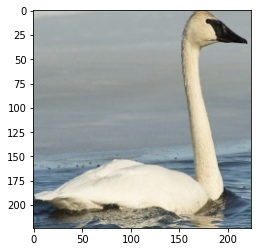

Label (number): 9, (name): TRUMPTER SWAN
[('BARN OWL', 0.359855055809021), ('TRUMPTER SWAN', 0.3342616558074951), ('PELICAN', 0.07676923274993896), ('ALBATROSS', 0.05858919024467468), ('BALD EAGLE', 0.053369294852018356), ('MALLARD DUCK', 0.047404635697603226), ('FLAMINGO', 0.04104510322213173), ('OSTRICH', 0.025146786123514175), ('EURASIAN MAGPIE', 0.0034285448491573334), ('PEACOCK', 0.00013039282930549234)]


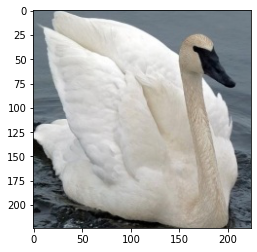

Label (number): 9, (name): TRUMPTER SWAN
[('BARN OWL', 0.37994635105133057), ('TRUMPTER SWAN', 0.34515219926834106), ('BALD EAGLE', 0.16729913651943207), ('FLAMINGO', 0.04544367641210556), ('ALBATROSS', 0.04156125336885452), ('PELICAN', 0.016665641218423843), ('MALLARD DUCK', 0.001805866602808237), ('OSTRICH', 0.0016721680294722319), ('EURASIAN MAGPIE', 0.0004197758389636874), ('PEACOCK', 3.3927779441000894e-05)]


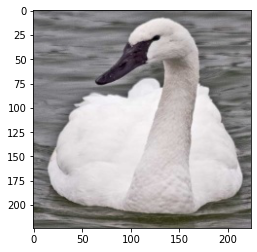

Label (number): 9, (name): TRUMPTER SWAN
[('TRUMPTER SWAN', 0.967434287071228), ('ALBATROSS', 0.01652618870139122), ('BALD EAGLE', 0.006161561235785484), ('PELICAN', 0.005027838051319122), ('BARN OWL', 0.001959787681698799), ('EURASIAN MAGPIE', 0.0015583443455398083), ('FLAMINGO', 0.0010466879466548562), ('MALLARD DUCK', 0.00015821639681234956), ('OSTRICH', 0.00012440844147931784), ('PEACOCK', 2.630011749715777e-06)]


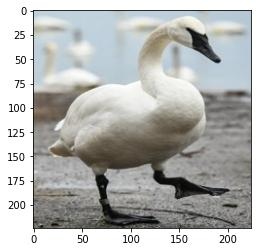

Label (number): 9, (name): TRUMPTER SWAN
[('BARN OWL', 0.3364587724208832), ('TRUMPTER SWAN', 0.25506579875946045), ('ALBATROSS', 0.16772136092185974), ('PELICAN', 0.08785203099250793), ('BALD EAGLE', 0.060113415122032166), ('OSTRICH', 0.02814388833940029), ('FLAMINGO', 0.023961644619703293), ('EURASIAN MAGPIE', 0.022829128429293633), ('MALLARD DUCK', 0.017185263335704803), ('PEACOCK', 0.0006687670247629285)]


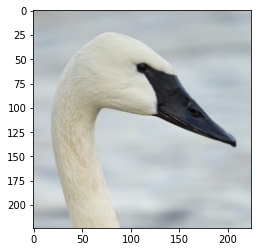

Label (number): 9, (name): TRUMPTER SWAN
[('TRUMPTER SWAN', 0.3773234486579895), ('MALLARD DUCK', 0.14302007853984833), ('PELICAN', 0.13875983655452728), ('ALBATROSS', 0.11590494960546494), ('OSTRICH', 0.06866716593503952), ('BALD EAGLE', 0.05778728425502777), ('BARN OWL', 0.050587695091962814), ('FLAMINGO', 0.028956778347492218), ('EURASIAN MAGPIE', 0.01831200160086155), ('PEACOCK', 0.0006807303288951516)]


In [11]:
#function for displaying a picture
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

display_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
for data in display_dataloader:
    images, labels = data
    # calculate outputs by running images through the network
    outputs = net(images)
    img = images[0].squeeze()
    label = labels[0].item()
    imshow(img)
    label_str = test_dataset.labels_int_to_str[label]
    print(f"Label (number): {label}, (name): {label_str}")
    prob_tensor = nn.Softmax(dim=1)(outputs.data).squeeze()
    prob_list = prob_tensor.tolist()
    prob_labels = [(test_dataset.labels_int_to_str[i], prob) for i, prob in enumerate(prob_list)]
    prob_labels.sort(key = lambda t : t[1], reverse=True)
    
    print(prob_labels)
